<a href="https://colab.research.google.com/github/agusekominarno/computer_vision/blob/main/neural_network/convolutional_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Download dataset
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2021-10-08 04:06:47--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.125.128, 142.250.157.128, 142.251.8.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  23.1MB/s    in 2.8s    

2021-10-08 04:06:51 (23.1 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [2]:
# Ekstrak dataset

import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [3]:
# Definisikan path untuk data train dan data validation

base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [4]:
import cv2
import numpy as np

# Gather data train
train_data = []
train_label = []
for r, d, f in os.walk(train_dir):
    for file in f:
        if ".jpg" in file:
            imagePath = os.path.join(r, file)
            image = cv2.imread(imagePath)
            image = cv2.resize(image, (150,150))
            train_data.append(image)
            label = imagePath.split(os.path.sep)[-2]
            train_label.append(label)

train_data = np.array(train_data)
train_label = np.array(train_label)

In [5]:
# Gather data validation
val_data = []
val_label = []
for r, d, f in os.walk(validation_dir):
    for file in f:
        if ".jpg" in file:
            imagePath = os.path.join(r, file)
            image = cv2.imread(imagePath)
            image = cv2.resize(image, (150,150))
            val_data.append(image)
            label = imagePath.split(os.path.sep)[-2]
            val_label.append(label)

val_data = np.array(val_data)
val_label = np.array(val_label)

<h3>Data Preprocessing</h3>

In [6]:
# Tampilkan shape dari data train dan data validation
print("Train Data = ", train_data.shape)
print("Train Label = ", train_label.shape)
print("Validation Data = ", val_data.shape)
print("Validation Label = ", val_label.shape)

Train Data =  (2000, 150, 150, 3)
Train Label =  (2000,)
Validation Data =  (1000, 150, 150, 3)
Validation Label =  (1000,)


In [7]:
# Normalisasi dataset
print("Data sebelum di-normalisasi ", train_data[0][0][0])

x_train = train_data.astype('float32') / 255.0
x_val = val_data.astype('float32') / 255.0
print("Data setelah di-normalisasi ", x_train[0][0][0])

Data sebelum di-normalisasi  [ 79 105 117]
Data setelah di-normalisasi  [0.30980393 0.4117647  0.45882353]


In [8]:
# Transformasi label encoder
from sklearn.preprocessing import LabelEncoder

print("Label sebelum di-encoder ", train_label[995:1005])

lb = LabelEncoder()
y_train = lb.fit_transform(train_label)
y_val = lb.fit_transform(val_label)

print("Label setelah di-encoder ", y_train[995:1005])

Label sebelum di-encoder  ['dogs' 'dogs' 'dogs' 'dogs' 'dogs' 'cats' 'cats' 'cats' 'cats' 'cats']
Label setelah di-encoder  [1 1 1 1 1 0 0 0 0 0]


<h3>Definisikan Model</h3>

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, MaxPool2D, Flatten

In [10]:
# Feature Extraction Layer
model = Sequential()

model.add(InputLayer(input_shape=[150,150,3]))
model.add(Conv2D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2, padding='same'))
model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2, padding='same'))
model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2, padding='same'))
model.add(Flatten())

In [11]:
# Fully Connected Layer
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [12]:
# Print model summary
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 38, 38, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 19, 19, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 23104)             0

In [13]:
# Compile model
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(lr=0.001), 
              loss='binary_crossentropy', 
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


<h3>Training Model</h3>

In [14]:
H = model.fit(x_train, y_train, batch_size=20, epochs=15, validation_data=(x_val, y_val))

Epoch 1/15
100/100 [==============================] - 48s 470ms/step - loss: 0.7008 - acc: 0.5255 - val_loss: 0.6705 - val_acc: 0.6220
Epoch 2/15
100/100 [==============================] - 47s 469ms/step - loss: 0.6641 - acc: 0.6010 - val_loss: 0.6371 - val_acc: 0.6300
Epoch 3/15
100/100 [==============================] - 47s 473ms/step - loss: 0.6036 - acc: 0.6775 - val_loss: 0.6224 - val_acc: 0.6660
Epoch 4/15
100/100 [==============================] - 47s 469ms/step - loss: 0.5450 - acc: 0.7280 - val_loss: 0.6035 - val_acc: 0.6830
Epoch 5/15
100/100 [==============================] - 47s 471ms/step - loss: 0.5052 - acc: 0.7455 - val_loss: 0.5771 - val_acc: 0.7100
Epoch 6/15
100/100 [==============================] - 47s 471ms/step - loss: 0.3794 - acc: 0.8215 - val_loss: 0.6886 - val_acc: 0.6750
Epoch 7/15
100/100 [==============================] - 47s 472ms/step - loss: 0.3120 - acc: 0.8655 - val_loss: 0.7393 - val_acc: 0.6960
Epoch 8/15
100/100 [==============================] - 4

<h3>Evaluasi Model</h3>

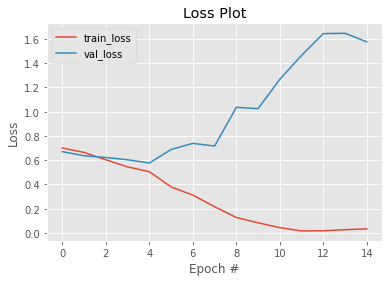

In [15]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 15), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 15), H.history["val_loss"], label="val_loss")
plt.title("Loss Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

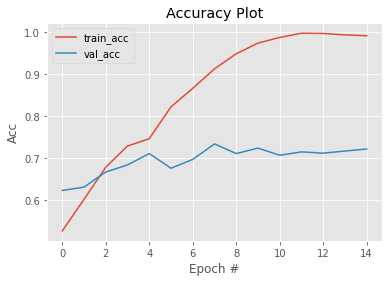

In [16]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 15), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, 15), H.history["val_acc"], label="val_acc")
plt.title("Accuracy Plot")
plt.xlabel("Epoch #")
plt.ylabel("Acc")
plt.legend()
plt.show()

In [17]:
from sklearn.metrics import classification_report

pred = model.predict(x_val)
labels = (pred > 0.5).astype(np.int)

print(classification_report(y_val, labels))

              precision    recall  f1-score   support

           0       0.74      0.68      0.71       500
           1       0.71      0.76      0.73       500

    accuracy                           0.72      1000
   macro avg       0.72      0.72      0.72      1000
weighted avg       0.72      0.72      0.72      1000

